In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from alive_progress import alive_bar
import time

## Dataset handling

In [ ]:
file_path = './data/train_images-1/'
images = os.listdir(file_path)
type(images)

list

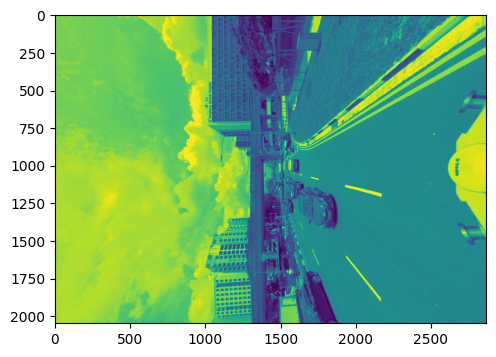

In [3]:
# see the first image
# cv2 reads in BGR format instead of RGB, so need to convert
plt.figure(figsize=(12,4))
img = cv2.imread(file_path + images[0], 0)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(img)

In [4]:
train_labels = pd.read_csv("./data/train_labels.csv", delimiter=",")
train_labels.head()

,Filename,TrajectoryId,Timestamp,Easting,Northing,Height,Roll,Pitch,Yaw
0,180502_025112897_Camera_0.jpg,1,2018-05-02 02:51:12.897,34768.9649,42018.1341,15.2489,153.736106,85.940147,-40.957096
1,180502_025113792_Camera_0.jpg,1,2018-05-02 02:51:13.792,34778.6576,42015.2686,15.3827,151.596473,86.596676,-44.765011
2,180502_025114667_Camera_0.jpg,1,2018-05-02 02:51:14.667,34788.2019,42012.2234,15.5128,164.269207,86.387958,-32.456497
3,180502_025115519_Camera_0.jpg,1,2018-05-02 02:51:15.519,34797.7536,42009.2379,15.6768,171.573787,85.015664,-24.603357
4,180502_025116352_Camera_0.jpg,1,2018-05-02 02:51:16.352,34807.4525,42006.2781,15.9175,178.834049,86.007892,-17.139556


In [5]:
def clean_train_labels(train_labels):
    # we have to convert the values in Timestamp to a float format, or it won't fit in the matrix later
    # to do this, we convert the Timestamp column to an integer that represents the time elapse since the start of the data
    # we need to note the TrajectoryID column, since the timings differ for each TrajectoryID 

    # create a copy cuz idw to mess it up
    train_labels_copy = train_labels.copy()

    # find the first Timestamp for each TrajectoryID)
    timestamps = pd.to_datetime(train_labels_copy.groupby('TrajectoryId')['Timestamp'].min())

    # create a 'date_delta' column that represents the time elapse since the start of the data
    # we can do this by subtracting the first Timestamp for each TrajectoryID from the Timestamp for each row
    # we divide by np.timedelta64(1,'s') to convert the time delta to seconds
    train_labels_copy['date_delta'] = (pd.to_datetime(train_labels_copy["Timestamp"]) - pd.to_datetime(timestamps[train_labels_copy["TrajectoryId"]].values)) / np.timedelta64(1, 's')
    return train_labels_copy

In [6]:
calib = pd.read_json('../data/intrinsic_parameters.json', orient='index')
calib
# fx and fy are the focal lengths expressed in pixel units.
# cx and cy are the coordinates of the optical center of the camera, also expressed in pixel units.
# k1, k2, k3, k4, p1, p2 are the distortion coefficients.

,0
fx,935.646182
fy,935.777993
Cx,1501.827899
Cy,1016.171354
k1,0.000000
k2,0.000000
k3,0.000000
k4,0.000000
P1,0.000000
P2,0.000000


In [7]:
class Dataset_Handler():

    def __init__(self, trajectory_id, progress_bar=True, low_memory=False):
        """
        Unpacks the images and returns a list
        
        Args:
        trajectory_id: the id of the trajectory we want to get the pictures for
        progress_bar: whether or not to show a progress bar
        low_memory: whether or not to load all the images into memory at once

        Returns:
        images: a list of images
        """

        self.img_dir = f"./data/train_images-{trajectory_id}/"
        train_labels_original = pd.read_csv("./data/train_labels.csv", delimiter=",")
        train_labels = clean_train_labels(train_labels_original)

        self.img_files = sorted(os.listdir(self.img_dir))
        self.num_frames = len(self.img_files)

        # gt stands for ground truth, 7 is the number of columns in the ground truth file.
        # assume the train_labels.csv and train_images are arranged in the same order.
        self.gt = np.zeros((self.num_frames, 7))
        for i in range(len(train_labels)):
            # if the trajectory id matches the 2nd column
            if train_labels.iloc[i, 1] == trajectory_id: 
                # populate the gt matrix with the ground truth values
                self.gt[i] = train_labels.iloc[i, 3:10]
        # load the intrinsic parameters
        calib = pd.read_json('./data/intrinsic_parameters.json', orient='index')
        self.fx = calib.iloc[0, 0]
        self.fy = calib.iloc[1, 0]
        self.cx = calib.iloc[2, 0]
        self.cy = calib.iloc[3, 0]

        if low_memory:
            self.reset_frames()
            self.first_image = cv2.imread(self.img_dir + self.img_files[0],0)
            self.second_image = cv2.imread(self.img_dir + self.img_files[1],0)
            self.imheight = self.first_image.shape[0]
            self.imwidth = self.first_image.shape[1]

        else:
            self.images = []
            if progress_bar:
                with alive_bar(self.num_frames) as bar:
                    for i, img_name in enumerate(self.img_files):
                        self.images.append(cv2.imread(self.img_dir + img_name, 0))
                        self.imheight = self.images[0].shape[0]
                        self.imwidth = self.images[0].shape[1]
                        bar()
    def reset_frames(self):
        self.images = (cv2.imread(self.img_dir + img, 0) for img in self.img_files)
        pass

In [8]:
handler = Dataset_Handler("1")

|████████████████████████████████████████| 1399/1399 [100%] in 34.8s (40.23/s) 


## Determine depth

In [9]:
import torch

In [70]:
# using pre-trained MiDaS model for monocular depth estimation
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

# uncomment the stuff below if you want to see the depth map

def calc_depth_map(img, model_type='DPT_Large'):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    # fig, axes = plt.subplots(1, 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    # axes[0].imshow(img)
    # axes[0].set_title('Original')
    # axes[1].imshow(output)
    # axes[1].set_title('Depth Map')
    depth_map = output.astype(np.float32)
    return depth_map

In [71]:
depth_map = calc_depth_map(handler.images[0], model_type = "MiDaS_small")

Using cache found in /Users/yj/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/yj/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/yj/.cache/torch/hub/intel-isl_MiDaS_master


In [64]:
depth_at_pixel = depth_map[0, 0]
print(f"Depth at pixel (0, 0): {depth_at_pixel}")

Depth at pixel (0, 0): 249.76571655273438


## Feature detection and matching

In [13]:
def extract_features(image, detector='sift', mask=None):
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    else:
        raise Exception('Invalid detector type')
    kp, des = det.detectAndCompute(image, mask)
    return kp, des

In [14]:
def match_features(des1, des2, matcher='BF', detector='sift', sort=True, k=2):
    if matcher == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matcher == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)

    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance)
    
    return matches

In [15]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [16]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Loading weights:  None


Using cache found in /Users/yj/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/yj/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/yj/.cache/torch/hub/intel-isl_MiDaS_master


Number of matches before filtering: 7588
Number of matches after filtering: 21


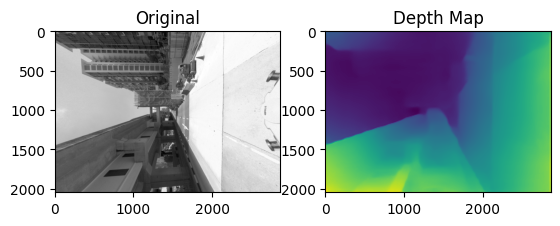

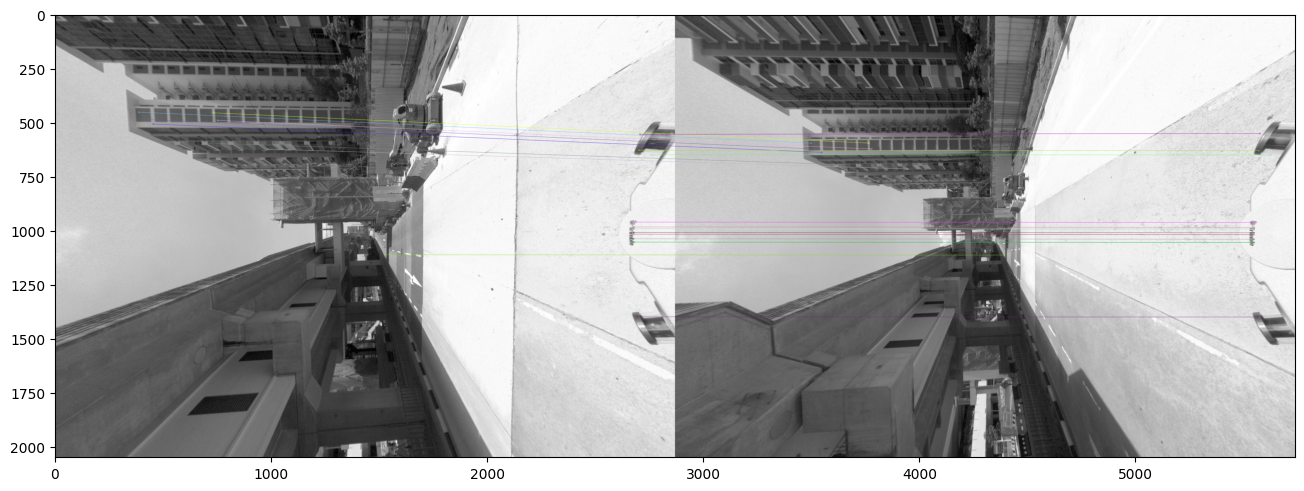

In [17]:
image1 = handler.images[0]
image2 = handler.images[1]
depth = calc_depth_map(image1, model_type = "MiDaS_small")
kp1, des1 = extract_features(image1, detector='sift')
kp2, des2 = extract_features(image2, detector='sift')
matches = match_features(des1, des2, matcher='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image1, kp1, image2, kp2, matches)

## Calculate Camera Pose (method: using m.distance as the depth)

In [35]:
intrinsic = {
  "fx": 935.6461822571149,
  "fy": 935.7779926708049,
  "Cx": 1501.8278990534407,
  "Cy": 1016.1713538034546,
  "k1": 0,
  "k2": 0,
  "k3": 0,
  "k4": 0,
  "P1": 0,
  "P2": 0
}

def calc_camera_pose(img1, img2):
    """
    Calculate the camera pose from two images

    Arguments:
    img1 -- the first image in a matched image pair
    img2 -- the second image in a matched image pair

    Returns:
    R -- rotation matrix (3x3)
    T -- translation vector (3x1)
    """
    # extract features from the two images
    kp1, des1 = extract_features(img1, detector='sift')
    kp2, des2 = extract_features(img2, detector='sift')

    # match features between the two images
    matches = match_features(des1, des2, matcher='BF', detector='sift', sort=True)
    matches = filter_matches_distance(matches, 0.3)
    
    # objectPoints is supposed to be a 3D, but the matches we get is only 2D.
    # so I used the distance as the z coordinate, but not sure if that's correct or na
    objPoints = np.array([np.float32([*kp1[m.queryIdx].pt, m.distance]) for m in matches]).reshape(-1, 1, 3)
    objPoints = np.squeeze(objPoints, axis=1)

    imgPoints = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32).reshape(-1, 1, 2)
    imgPoints = np.squeeze(imgPoints, axis=1)

    # calculate the camera pose from the matched features
    # however, solve.PnP will give an error if there are less than 6 matches
        # in that case, we just return 0 for R and T
    if len(matches) < 6:
        return np.zeros((3,3)), np.zeros((3,1))
    retval, R, T = cv2.solvePnP(
        objectPoints=objPoints,
        imagePoints=imgPoints,
        cameraMatrix=np.array([
            [intrinsic['fx'], 0, intrinsic['Cx']],
            [0, intrinsic['fy'], intrinsic['Cy']],
            [0, 0, 1]
        ], dtype=np.float32),
        distCoeffs=np.zeros(4, dtype=np.float32)
    )
    # to convert R from a 3x1 to a 3x3 matrix
    R = cv2.Rodrigues(R)[0]

    return R, T

In [57]:
import csv

def export_camera_poses(camera_poses, output_file):
  """Converts a list of arrays to a CSV file with the specified column headers.

  Args:
    list_of_arrays: A list of arrays. Each array must have the same number of
      elements.
    output_file: The path and name of the output CSV file.
  """
  header = ['r11', 'r12', 'r13', 't1', 'r21', 'r22', 'r23', 't2', 'r31', 'r32', 'r33', 't3']
  with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for item in camera_poses:
        row = []
        for array in item:
            for value in array.flatten():
                row.append(value)
        writer.writerow(row)


In [58]:
# calculate the camera pose for all the images, and store them as a csv file
def calc_all_camera_poses(handler):
    """
    Calculate the camera pose for all the images in a dataset

    Arguments:
    handler -- the handler for the dataset

    Returns:
    camera_poses -- a list of camera poses for all the images
    """
    camera_poses = []
    with alive_bar(handler.num_frames - 1) as bar:
        for i in range(handler.num_frames - 1):
            R, T = calc_camera_pose(handler.images[i], handler.images[i+1])
            camera_poses.append(np.hstack((R, T)))
            bar()
    return camera_poses

In [59]:
# calculating all the camera poses for train_images_1
# camera_poses_1 = calc_all_camera_poses(handler)

|████████████████████████████████████████| 1398/1398 [100%] in 3:36:04.1 (0.11/s) 


In [60]:
# exporting to csv
# export_camera_poses(camera_poses_1, 'camera_poses_1_d.csv')

In [62]:
# read the csv 
camera_poses_1 = pd.read_csv("camera_poses_1.csv", delimiter=",")
camera_poses_1.head()

,r11,r12,r13,t1,r21,r22,r23,t2,r31,r32,r33,t3
0,-0.993762,-0.012543,0.110817,1495.556497,0.013103,-0.999905,0.004326,978.383799,0.110752,0.005751,0.993831,-1301.137457
1,-0.995379,-0.006335,0.095813,1501.650249,0.003416,-0.999526,-0.030598,1007.717235,0.095961,-0.030129,0.994929,-1226.526989
2,-0.999234,0.011237,0.037493,1515.188529,-0.004896,-0.986263,0.165109,1003.806683,0.038833,0.164799,0.985562,-1246.525121
3,0.998552,-0.009326,0.052975,-1476.943789,0.003096,0.993187,0.116491,-1023.984921,-0.053700,-0.116158,0.991778,1133.004573
4,-0.995385,0.011050,-0.095320,1504.376217,-0.013034,-0.999711,0.020217,1032.173380,-0.095069,0.021366,0.995241,-1057.729528


## Calculate Camera Pose (method 2: using depth from depth map)

In [81]:
intrinsic = {
  "fx": 935.6461822571149,
  "fy": 935.7779926708049,
  "Cx": 1501.8278990534407,
  "Cy": 1016.1713538034546,
  "k1": 0,
  "k2": 0,
  "k3": 0,
  "k4": 0,
  "P1": 0,
  "P2": 0
}

def calc_camera_pose_v2(img1, img2):
    """
    Calculate the camera pose from two images

    Arguments:
    img1 -- the first image in a matched image pair
    img2 -- the second image in a matched image pair

    Returns:
    R -- rotation matrix (3x3)
    T -- translation vector (3x1)
    """
    R, T = np.eye(3), np.zeros((3, 1))

    # extract features from the two images
    kp1, des1 = extract_features(img1, detector='sift')
    kp2, des2 = extract_features(img2, detector='sift')

    # match features between the two images
    matches = match_features(des1, des2, matcher='BF', detector='sift', sort=True)
    matches = filter_matches_distance(matches, 0.3)
    
    # however, solve.PnP will give an error if there are less than 6 matches
        # in that case, we just return 0 for R and T
    if len(matches) < 6:
        return np.zeros((3,3)), np.zeros((3,1))

    # objectPoints is supposed to be a 3D, but the matches we get is only 2D.
    # now we use the depth map to get the z coordinate
    img1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    img2_points = np.float32([kp2[m.trainIdx].pt for m in matches])

    depth = calc_depth_map(img1, model_type = "MiDaS_small")

    # get the depth map
    object_points = np.zeros((0,3))
    for i, (u,v) in enumerate(img1_points):
        z = depth[int(v), int(u)]
        
        # since u and v are pixel coordinates, we need to convert them to meters by subtract the optical center and multiplying by the focal length
        x = z * (u - intrinsic['Cx']) / intrinsic['fx']
        y = z * (v - intrinsic['Cy']) / intrinsic['fy']

        object_points = np.vstack([object_points, np.array([x, y, z])])

    _, R, T, _ = cv2.solvePnPRansac(
        object_points, 
        img2_points, 
        cameraMatrix=np.array([
          [intrinsic['fx'], 0, intrinsic['Cx']],
          [0, intrinsic['fy'], intrinsic['Cy']],
          [0, 0, 1]
          ], dtype=np.float32),
          distCoeffs=np.zeros(4, dtype=np.float32)
        )
    
    R = cv2.Rodrigues(R)[0]

    return R, T

In [85]:
R,T = calc_camera_pose_v2(handler.images[0], handler.images[300])
print("Rotation Matrix:\n", R)
print("Translation Vector:\n", T)

Rotation Matrix:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Translation Vector:
 [[0.]
 [0.]
 [0.]]


In [86]:
# calculating all the camera poses for train_images_1
camera_poses_1 = calc_all_camera_poses(handler)

|███▉⚠︎                                   | (!) 135/1398 [10%] in 12:08.4 (0.19/s) 


KeyboardInterrupt: 

In [ ]:
# exporting to csv
export_camera_poses(camera_poses_1, 'camera_poses_1_dm.csv')